In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\desse\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


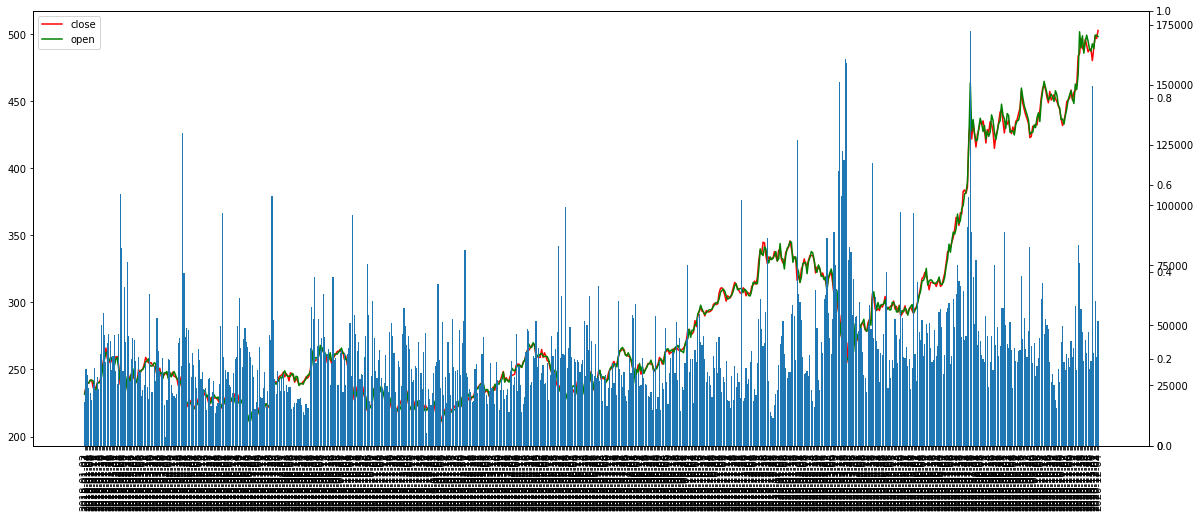

In [74]:
from FinMind.Data import Load
TaiwanStockInfo = Load.FinData(dataset = 'TaiwanStockInfo')
data = Load.FinData(dataset = 'TaiwanStockPrice',select = '2330',date = '2018-01-01')

fig=plt.figure(figsize=(20,8))
plt.xticks(rotation = 90)  
ax1 = plt.subplot(111)
ax1.plot(data.close,color='red',label='close')
ax1.plot(data.open,color='green',label='open')
plt.legend()
# twin 為共享x軸
ax2= ax1.twinx()
plt.bar(data.date,data.Trading_Volume.astype('int')//1000)
ax3 = ax1.twinx()

In [75]:
# train, test split
train_size = int(len(data) * 0.7)
test_size = len(data) - train_size
train, test = data[0:train_size], data[train_size:len(data)]

print('Training size: ', train_size)
print('Test size: ', test_size)

#只要Volume
train_set = train['Trading_Volume']
test_set = test['Trading_Volume']

# MinMaxScale
from sklearn.preprocessing import MinMaxScaler 
sc = MinMaxScaler(feature_range = (0, 1))
train_set = train_set.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(train_set)

print('training_set_scaled:\n',training_set_scaled[0:5])

Training size:  500
Test size:  215
training_set_scaled:
 [[0.1144334 ]
 [0.22252775]
 [0.20252178]
 [0.15929965]
 [0.14445588]]


In [76]:
look_back=2
X_train = [] 
y_train = []
for i in range(look_back,len(train_set)):
    X_train.append(training_set_scaled[i-look_back:i-1, 0]) 
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train) 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

print('用第',look_back-1,'天之前的股價:')
print(X_train[0])
print('預測第',look_back-1,'天的股價:')
print(y_train[0])

用第 1 天之前的股價:
[[0.1144334]]
預測第 1 天的股價:
0.20252178039282606


Epoch 1/100
50/50 [==============================] - 0s 774us/step - loss: 0.0211
Epoch 2/100
50/50 [==============================] - 0s 724us/step - loss: 0.0148
Epoch 3/100
50/50 [==============================] - 0s 655us/step - loss: 0.0146
Epoch 4/100
50/50 [==============================] - 0s 645us/step - loss: 0.0148
Epoch 5/100
50/50 [==============================] - 0s 625us/step - loss: 0.0147
Epoch 6/100
50/50 [==============================] - 0s 640us/step - loss: 0.0146
Epoch 7/100
50/50 [==============================] - 0s 704us/step - loss: 0.0147
Epoch 8/100
50/50 [==============================] - 0s 655us/step - loss: 0.0150
Epoch 9/100
50/50 [==============================] - 0s 625us/step - loss: 0.0152
Epoch 10/100
50/50 [==============================] - 0s 765us/step - loss: 0.0152
Epoch 11/100
50/50 [==============================] - 0s 645us/step - loss: 0.0149
Epoch 12/100
50/50 [==============================] - 0s 664us/step - loss: 0.0147
Epoch 13/100


50/50 [==============================] - 0s 655us/step - loss: 0.0146
Epoch 100/100
50/50 [==============================] - 0s 675us/step - loss: 0.0148


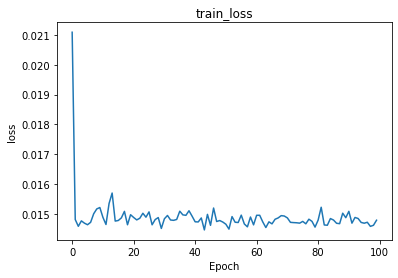

In [77]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

model = Sequential()
model.add(SimpleRNN(units = 100, input_shape = (X_train.shape[1],1)))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = 100, batch_size = 10)
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])

In [78]:
dataset_total = pd.concat((train['Trading_Volume'], test['Trading_Volume']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i-1, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = model.predict(X_test)
# inverse_transform將股價轉為歸一化前
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

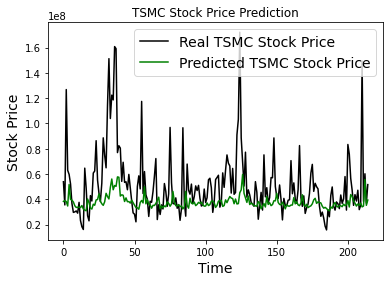

In [79]:
# Plot prediction vs Real
plt.plot(test['Trading_Volume'].values, color = 'black', label = 'Real TSMC Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted TSMC Stock Price')
plt.title('TSMC Stock Price Prediction')
plt.xlabel('Time',size=14)
plt.ylabel('Stock Price',size=14)
plt.legend(fontsize=14)
plt.show()